In [1]:
import instruments as inst
import copy
import numpy as np
import json

# Step 1.a): Reading in csv - extracting single diffs and sums and configurations

In [2]:
file_path = "20230914_processed_table.csv"
wavelength_string = "725-50"
obs_mode = "IPOL"

interleaved_values, interleaved_stds, configuration_list = inst.read_csv(file_path, 
    obs_mode = obs_mode, obs_filter = wavelength_string)
# print("Interleaved Values")
# print("Length: ", len(interleaved_values))
# print(interleaved_values)
# print("Interleaved Stds")
# print("Length: ", len(interleaved_stds))
# print(interleaved_stds[0 : 10])
# print("Configuration List")
# print("Length: ", len(configuration_list))
# print(configuration_list)
# print(interleaved_stds[0])

# Step 1.b) - Make plot of existing values as double diffs and sums

# Step 2: Creating a system Mueller matrix object

In [3]:
import numpy as np
past_fit = np.load("scipy_minimize_20230914_720nm_restrictive_HWP_and_IMR.npy")
print("Past Fit: ", past_fit)

Past Fit:  [ 4.99984042  0.44887049  1.08704114  0.40140005 -4.99999346 -0.21697373
  0.09999933 21.36101844  0.51787551  0.43110147  1.18869275]


In [4]:
# Loading in previous fit from vampires_calibration
past_fit = np.load("scipy_minimize_20230914_720nm_restrictive_HWP_and_IMR.npy")
print("Past Fit: ", past_fit)

print(past_fit)

# theta_pol = past_fit[0]
# delta_HWP = past_fit[1]
# offset_HWP = past_fit[2]
# delta_derot = past_fit[3]
# offset_derot = past_fit[4]
# delta_opts = past_fit[5]
# epsilon_opts = past_fit[6]
# rot_opts = past_fit[7]
# delta_FLC = past_fit[8]
# rot_FLC = past_fit[9]
# em_gain = past_fit[10]

theta_pol = -1.407251668252865
delta_HWP = 0.48086201221157854
offset_HWP = -4.3919526835473945
delta_derot = 0.46141994584131574
offset_derot = -3.8625317442765326
delta_opts = 0.08315976670546754
epsilon_opts = 0.00783670716385955
rot_opts = -35.158483822636384
delta_FLC = 0.5175091765357993
rot_FLC = 4.848758257884221
em_gain = 1.1983206687491288

# Based on values in Six_And_Eleven_Parameter_Model_Best_MCMC_and_Scipy_Fits Google Sheets - having zeros for angles that're too large
# theta_pol = 0
# delta_HWP = 0.451  # Add your actual delta_HWP value
# offset_HWP = -2.64  # Add your actual offset_HWP value
# delta_derot = 0.32  # Add your actual delta_derot value
# offset_derot = 0  # Add your actual offset_derot value
# delta_opts = 0  # Add your actual delta_opts value
# epsilon_opts = 0  # Add your actual epsilon_opts value
# rot_opts = 0  # Add your actual rot_opts value
# delta_FLC = 0.5  # Add your actual delta_FLC value
# rot_FLC = 0  # Add your actual rot_FLC value
# em_gain = 1.2  # Add your actual em_gain value

# NOTE: Components must be listed downstream to upstream
# Define the instrument configuration as a system dictionary


system_dict = {
    "components": {
        "wollaston": {
            "type": "wollaston_prism_function",
            "properties": {"beam": "o", "transmission_ratio": em_gain},
        },
        "dichroic": {
            "type": "diattenuator_retarder_function",
            "properties": {'phi': 0, 'epsilon': 0, 'theta': 0},
        },
        "flc": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_FLC, "theta": 0, "delta_theta": rot_FLC},
        },
        "optics": {
            "type": "diattenuator_retarder_function",
            "properties": {'phi': -2.476492298785013, 'epsilon': 0.00473325176939048, 'theta': 3.371657377970516},
        },
        "image_rotator": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_derot, "theta": 0, "delta_theta": 0},
        },
        "hwp": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_HWP, "theta": 0, "delta_theta": offset_HWP},
        },
        "lp": {
            "type": "general_linear_polarizer_function_with_theta",
            "properties": {"theta": theta_pol},
        },
    }
}

print(system_dict)

Past Fit:  [ 4.99984042  0.44887049  1.08704114  0.40140005 -4.99999346 -0.21697373
  0.09999933 21.36101844  0.51787551  0.43110147  1.18869275]
[ 4.99984042  0.44887049  1.08704114  0.40140005 -4.99999346 -0.21697373
  0.09999933 21.36101844  0.51787551  0.43110147  1.18869275]
{'components': {'wollaston': {'type': 'wollaston_prism_function', 'properties': {'beam': 'o', 'transmission_ratio': 1.1983206687491288}}, 'dichroic': {'type': 'diattenuator_retarder_function', 'properties': {'phi': 0, 'epsilon': 0, 'theta': 0}}, 'flc': {'type': 'general_retarder_function', 'properties': {'phi': 3.251606054340341, 'theta': 0, 'delta_theta': 4.848758257884221}}, 'optics': {'type': 'diattenuator_retarder_function', 'properties': {'phi': -2.476492298785013, 'epsilon': 0.00473325176939048, 'theta': 3.371657377970516}}, 'image_rotator': {'type': 'general_retarder_function', 'properties': {'phi': 2.8991870241497555, 'theta': 0, 'delta_theta': 0}}, 'hwp': {'type': 'general_retarder_function', 'propert

In [5]:
# Converting system dictionary into system Mueller Matrix object

system_mm = inst.generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())

[[ 0.58207109  0.58136896 -0.0285812   0.        ]
 [ 0.58207109  0.58136896 -0.0285812   0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]


# Step 4: Creating a dictionary of p0 starting guesses

logl value: 894.2940516599526


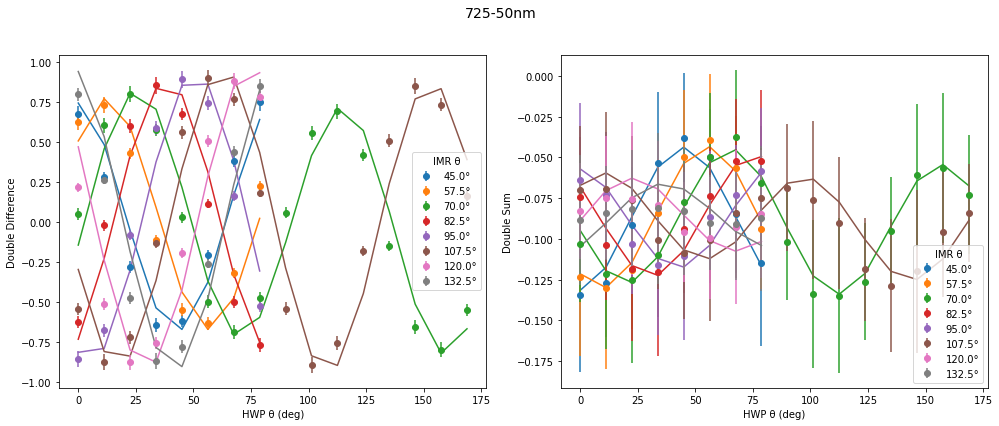

In [6]:
# Fittin for all parameters

p0 = {
    "wollaston": {"transmission_ratio": em_gain}, 
    "dichroic": {"phi": 0, 
                 "epsilon": 0, 
                 "theta": 0},
    "flc": {"phi": 2 * np.pi * delta_FLC, "delta_theta": rot_FLC},
    "optics": {"phi": 2 * np.pi * delta_opts, "epsilon": epsilon_opts, "theta": rot_opts},
    "image_rotator": {
                    "phi": 2 * np.pi * delta_derot, 
                    # "delta_theta": 0
                    },
    "hwp": {"phi": 2 * np.pi * delta_HWP, "delta_theta": offset_HWP},
    "lp": {"theta": theta_pol}
}

p0_values, p0_keywords = inst.parse_configuration(p0)
s_in = np.array([1, 0, 0, 0])
logl_value = inst.logl(p0_values, p0_keywords, system_mm, interleaved_values, interleaved_stds, configuration_list,
    s_in=s_in, logl_function=None, process_dataset=inst.process_dataset, process_errors=inst.process_errors, 
    process_model=inst.process_model)
print("logl value: " + str(logl_value))

# TODO: Add an initial plot block here
# Plotting intial plot
updated_system_mm = inst.update_system_mm(p0_values, p0_keywords, system_mm)
model = inst.model(p0_values, p0_keywords, system_mm, configuration_list, 
    process_model = inst.process_model)

inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
    configuration_list, wavelength = wavelength_string)

# Step 5: Running minimize_system_Mueller_matrix iteratively

Before p0: {'wollaston': {'transmission_ratio': 1.1983206687491288}, 'dichroic': {'phi': 0, 'epsilon': 0, 'theta': 0}, 'flc': {'phi': 3.251606054340341, 'delta_theta': 4.848758257884221}, 'optics': {'phi': 0.5225082243122758, 'epsilon': 0.00783670716385955, 'theta': -35.158483822636384}, 'image_rotator': {'phi': 2.8991870241497555}, 'hwp': {'phi': 3.021345129908601, 'delta_theta': -4.3919526835473945}, 'lp': {'theta': -1.407251668252865}}


Iteration #: 1
logl_value: 14.265497909723674
Best Fit Parameters: [ 1.16054181e+00 -7.56915643e-03  1.65789438e-02 -6.91863278e-03
  3.25577699e+00  3.99139061e+00  5.51455415e-01  4.43532850e-03
 -4.00485351e+01  2.89342563e+00  3.03425534e+00  3.45919807e+00
  4.95141011e+00]


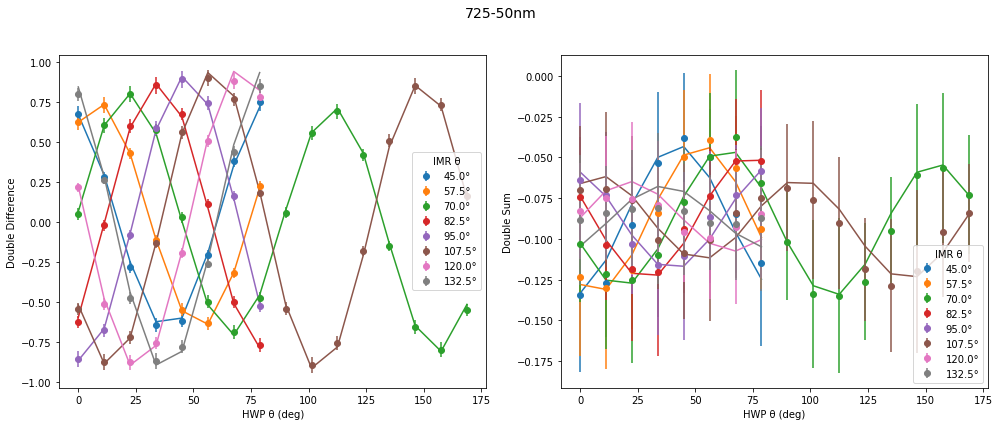

After p0: {'wollaston': {'transmission_ratio': 1.1605418127440044}, 'dichroic': {'phi': -0.00756915643495025, 'epsilon': 0.0165789437825399, 'theta': -0.006918632780969795}, 'flc': {'phi': 3.255776986185296, 'delta_theta': 3.991390608661856}, 'optics': {'phi': 0.5514554152198168, 'epsilon': 0.004435328499300017, 'theta': -40.0485350533599}, 'image_rotator': {'phi': 2.8934256284035893}, 'hwp': {'phi': 3.034255335324218, 'delta_theta': 3.459198074232811}, 'lp': {'theta': 4.9514101059727444}}
Before p0: {'wollaston': {'transmission_ratio': 1.1605418127440044}, 'dichroic': {'phi': -0.00756915643495025, 'epsilon': 0.0165789437825399, 'theta': -0.006918632780969795}, 'flc': {'phi': 3.255776986185296, 'delta_theta': 3.991390608661856}, 'optics': {'phi': 0.5514554152198168, 'epsilon': 0.004435328499300017, 'theta': -40.0485350533599}, 'image_rotator': {'phi': 2.8934256284035893}, 'hwp': {'phi': 3.034255335324218, 'delta_theta': 3.459198074232811}, 'lp': {'theta': 4.9514101059727444}}
Iteration

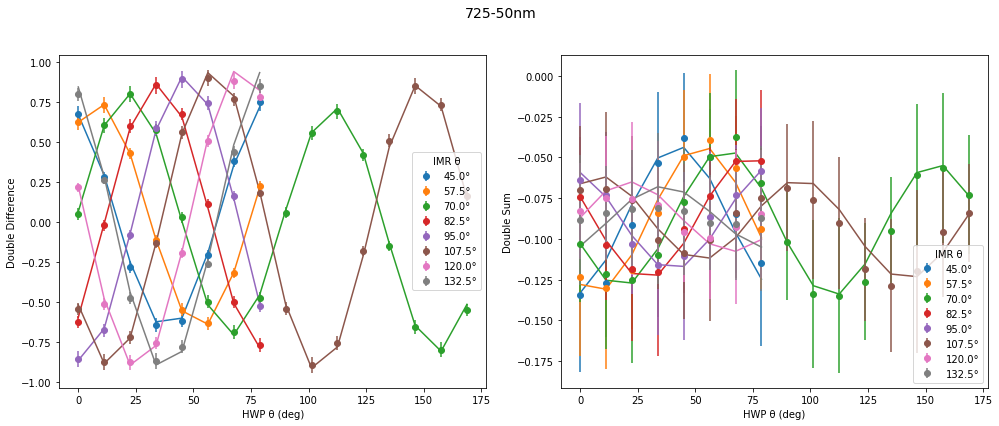

After p0: {'wollaston': {'transmission_ratio': 1.1564212957789048}, 'dichroic': {'phi': -0.008993624414963179, 'epsilon': 0.018482389580569993, 'theta': -0.007172417325267794}, 'flc': {'phi': 3.254754164606743, 'delta_theta': 4.071337175892329}, 'optics': {'phi': 0.5510028665782447, 'epsilon': 0.0039349157627214795, 'theta': -39.73119225284772}, 'image_rotator': {'phi': 2.8936096290210673}, 'hwp': {'phi': 3.0347536196537543, 'delta_theta': 3.409809501718911}, 'lp': {'theta': 4.999999960094904}}


In [7]:
# Unpolarized light for s_in as there is LP in the system already
s_in = np.array([1, 0, 0, 0])
bounds = [ 
    (0, 2),  # em_gain
    (-2 * np.pi, 2 * np.pi), # dichroic_retardance
    (0, 1), # dichroic_diattenuation
    (-90, 90), # dichroic_rotation_angle 
    (0.4 * 2 * np.pi, 0.6 * 2 * np.pi),  # delta_FLC
    (-5, 5),  # rot_FLC
    (-np.pi, np.pi),  # delta_opts
    (0, 0.1),  # epsilon_opts
    (-90, 90),  # rot_opts
    ((delta_derot - delta_derot * 0.1) * 2 * np.pi, (delta_derot + delta_derot * 0.1) * 2 * np.pi),  # delta_derot
    # (-1, 1),  # offset_derot
    ((delta_HWP - delta_HWP * 0.1) * 2 * np.pi, 0.5 * 2 * np.pi),  # delta_HWP
    (-5, 5),  # offset_HWP
    (-5, 5),  # theta_pol
]
# Counters for iterative fitting
iteration = 1
previous_logl_value = 1000000
new_logl_value = 0

while abs(previous_logl_value - new_logl_value) > 0.01 * abs(previous_logl_value):
    print("Before p0: " + str(p0))
    if iteration > 1: 
        previous_logl_value = new_logl_value
    result, new_logl_value = inst.minimize_system_mueller_matrix(p0, system_mm, 
        interleaved_values, interleaved_stds, configuration_list, s_in = s_in,
        process_dataset = inst.process_dataset, 
        process_errors = inst.process_errors, 
        process_model = inst.process_model, bounds = bounds)
    
    # Print statements
    print("Iteration #: " + str(iteration))
    print("logl_value: " + str(new_logl_value))
    print("Best Fit Parameters: " + str(result.x))

    # Making a plot
    updated_system_mm = inst.update_system_mm(result.x, p0_keywords, system_mm)
    model = inst.model(result.x, p0_keywords, updated_system_mm, configuration_list, 
    process_model = inst.process_model)

    inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
        configuration_list, wavelength = wavelength_string)

    # Updating p0 for next time
    inst.update_p0(p0, result.x)
    print("After p0: " + str(p0))

    iteration += 1

    filename = f"{wavelength_string}_restrictive_HWP_FLC_no_IMR_offset_with_dichroic_best_fit_old_fit_values.txt"
    with open(filename, 'w') as f:
        json.dump(p0, f, indent=4)

# Step 6: Plot model with best fit

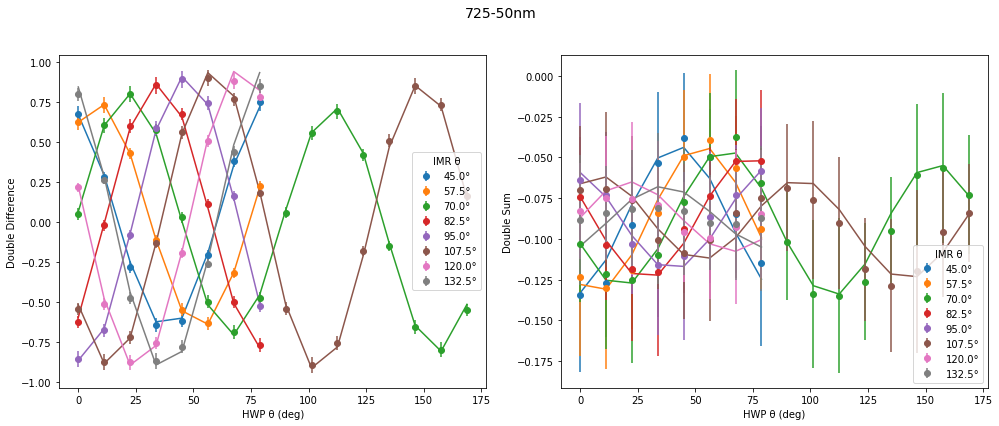

In [8]:
# Generate model with p0 keywords but scipy minimized results
# print(result.x)
# print(p0_keywords)

# Manually adjusting for a good fit
dichroic_phi = 0 # (waves)
dichroic_theta = 0 # (degrees)
# result.x = [2 * np.pi * dichroic_phi, dichroic_theta]

updated_system_mm = inst.update_system_mm(result.x, p0_keywords, system_mm)
model = inst.model(result.x, p0_keywords, system_mm, configuration_list, 
    process_model = inst.process_model)

inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
    configuration_list, wavelength = wavelength_string)